# Setup

In [299]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

## Load data

In [305]:
# Load dataframe
bd = pd.read_pickle("./data/batting_data_ch7.pkl")

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0_mle, beta0_mle = np.load(f)

## 8.2 Right- and left- handed batters
First we need to add the batter handedness to the dataframe. 

In [306]:
from pybaseball.lahman import people

people_data = people()

def get_batter_handedness(row,people_data):
    row["bats"] = people_data.loc[people_data.playerID.isin([row.playerID]),"bats"].item()
    return row

bd = bd.apply(lambda row: get_batter_handedness(row,people_data),axis=1)

Drop players w/o batting data and one-hot encode our batting column.

In [308]:
bd["bats"] = bd.bats.fillna("R")#,dropna(subset=["bats"])
bd = pd.get_dummies(bd, columns=['bats'])
# DO I NEED TO DROP A COLUMN HERE? YES IF STANDARD OLS, NO IF REGUlARIZATION ... need to test this

In [310]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    # Get H/AB 
    k, n, r, l, b = args # H, AB, R-handed, L-handed, Both-handed

    # The initial model assumed a fixed (alpha, beta):
    #        a, b = params[0], params[1]

    # Here, we take in the initial values of (mu_0, mu_ab, and sigma_0) to compute (alpha, beta):
    mu_0, mu_AB, sigma_0, r0, l0, b0 = params
    # Add batting term
    batting_term = r0*r + l0*l + b0*b
    mu_i = mu_0 + mu_AB*np.log(n) + batting_term
    # (alpha,beta) as before
    a = mu_i / sigma_0
    b = (1-mu_i)/sigma_0
    
    # Log pdf
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #


min_atbat = 0

# I am going to cheat here and use the values from the book as initial parameters since MLE is probably not the best choice here.
init_params = [ 0.14348183, 0.01514047, 0.00175561, 0.01,        0.01,    0.01]
param_bounds = [(0, 0.4), (0.001, 0.5),(.0001,.1),(-0.5,.5),(-0.5,.5),(-0.5,.5)]

# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(bd.loc[:,'H'], bd.loc[:,'AB'],bd.loc[:,'bats_R'],bd.loc[:,'bats_L'],bd.loc[:,'bats_B']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000},bounds=param_bounds)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63189D+04    |proj g|=  5.10000D-01

At iterate    1    f=  3.58849D+04    |proj g|=  5.04286D-01

At iterate    2    f=  3.57858D+04    |proj g|=  5.05177D-01

At iterate    3    f=  3.57188D+04    |proj g|=  5.06196D-01

At iterate    4    f=  3.57132D+04    |proj g|=  5.06256D-01

At iterate    5    f=  3.56915D+04    |proj g|=  5.05011D-01

At iterate    6    f=  3.56416D+04    |proj g|=  5.01830D-01

At iterate    7    f=  3.56158D+04    |proj g|=  5.02801D-01

At iterate    8    f=  3.56153D+04    |proj g|=  5.02649D-01

At iterate    9    f=  3.56143D+04    |proj g|=  5.02294D-01

At iterate   10    f=  3.56126D+04    |proj g|=  5.01539D-01

At iterate   11    f=  3.56098D+04    |proj g|=  5.01787D-01

At iterate   12    f=  3.56074D+04    |proj g|=  5.02636D-01

At iterate   13    f=  3.5

In [311]:
print(result)

      fun: 35600.50706288733
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.69602572, -7.95407686, -5.57120075, -0.38126018, -2.39451765,
        1.10958354])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 217
      nit: 24
     njev: 31
   status: 0
  success: True
        x: array([ 0.14124225,  0.01502693,  0.00165229,  0.00039194,  0.00955889,
       -0.00133924])


In [312]:
def new_eb_estimate(row,params,col_names=["alpha0_bat","beta0_bat","alpha1_bat","beta1_bat","eb_estimate_bat"]):

    # Get H and AB for each row
    H, AB, R, L, B = row.H, row.AB, row.bats_R, row.bats_L, row.bats_B
    
    # Get values from MLE results
    mu, mu_AB, sigma, r_, l_, b_ = params

    # Update alpha0 and beta0
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term) if AB > 0 else mu
    alpha0 = mu_i/sigma
    beta0 = (1-mu_i)/sigma

    # Update alpha1 and beta1
    alpha1 = alpha0 + H
    beta1  = beta0 + (AB - H)

    # New eb estimate
    new_eb_estimate = alpha1 / (alpha1 + beta1)

    # Update data
    row[col_names[0]] = alpha0 
    row[col_names[1]]  = beta0 
    row[col_names[2]] = alpha1
    row[col_names[3]]  = beta1
    row[col_names[4]] = new_eb_estimate

    return row

bd = bd.loc[bd.AB>0,:].apply(lambda row: new_eb_estimate(row,result.x),axis=1)

## Figure 8.1 
The prior distribution according to the hierarchical model for players with particular combinations of AB and handedness.

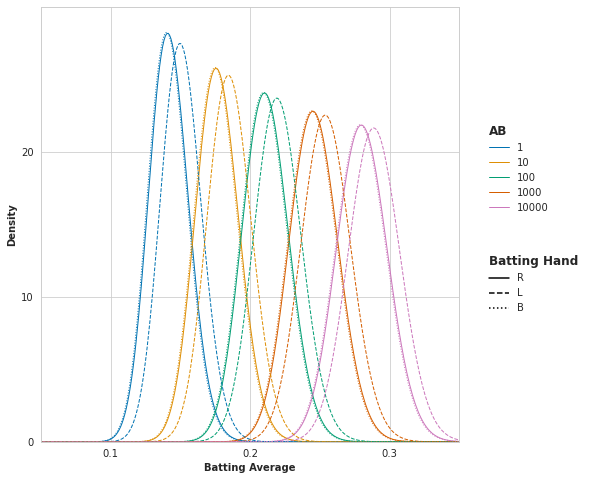

In [314]:
# Which ABs
ABs = [1,10,100,1000,10000]

def get_alpha0_beta0(params,AB=1,bats=[1,0,0]):
    # Convert to list if not lsit
    R,L,B = bats
    # Get params from MLE 
    # mu, mu_AB, sigma = .1426,.0153,np.exp(-6.2935)
    mu, mu_AB, sigma, r_, l_, b_ = params
    # sigma = np.exp(sigma)
    # Initialize and loop through each AB value
    alpha0, beta0 = [],[]
    # Update alpha0 and beta0
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term) if AB > 0 else mu
    a = mu_i / sigma
    b = (1-mu_i)/sigma

    return a, b # returns pair of alpha0,beta0 values

# Make figure - I know there are other ways to add a second legend but I prefer to use gridspec so I have complete control of everything..
with sns.axes_style("whitegrid"):
    
    # Create figure
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(7.5,8)

    # Add gridspecs
    gs0 = fig.add_gridspec(nrows=1, ncols=1)#, left=0.1, right=0.75,bottom=0.9,top=.99)#,width_ratios=[1,1,1])
    ax0 = fig.add_subplot(gs0[0],facecolor="w",)
    gs1 = fig.add_gridspec(nrows=1, ncols=1)
    ax1 = fig.add_subplot(gs1[0],facecolor="None",)
    
    # Define colors
    clrs = sns.color_palette("colorblind",n_colors=len(ABs))

    # Plot data for each AB/handed combo
    bat_vec = [[1,0,0],[0,1,0],[0,0,1]]
    bat_side = ["R","L","B"]
    linestyles = ["-","--",":"]
    x = np.linspace(0,1,1000)
    for (_bats,_batside,_linesty) in zip(bat_vec,bat_side,linestyles):
        for (clr,AB) in zip(clrs,ABs):
            a0,b0 = get_alpha0_beta0(result.x,AB,_bats)
            if _batside == "R": # add label
                ax0.plot(x,stats.beta.pdf(x,a0,b0),color=clr,lw=1,linestyle=_linesty,label="{}".format(AB))
            else: # no label
                ax0.plot(x,stats.beta.pdf(x,a0,b0),color=clr,lw=1,linestyle=_linesty)
    
    # Add invisible plots for batting hand
    for (_linesty,_bats) in zip(linestyles,bat_side):
        ax1.plot([], [], color="k", alpha=1, linestyle=_linesty, label="{}".format(_bats))

    # # Add legend and clean up
    ax0.legend(frameon=False,bbox_to_anchor=(1.05,.75),loc='upper left')   
    ax0.get_legend().set_title("AB",prop = {'size':12,'weight': "bold"})
    ax0.get_legend()._legend_box.align = "left"
    ax0.set_xlabel("Batting Average",fontweight="bold")
    ax0.set_ylabel("Density",fontweight="bold")
    ax0.set_xticks([0.1,0.2,0.3])
    ax0.set_xlim(0.05,.35)
    ax0.set_yticks([0,10,20])
    ax0.set_ylim(0,30)

    # Second legend and axes
    ax1.legend(frameon=False,bbox_to_anchor=(1.05,.45),loc='upper left')   
    ax1.get_legend().set_title("Batting Hand",prop = {'size':12,'weight': "bold"})
    ax1.get_legend()._legend_box.align = "left"
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)

## Figure 8.2
Empirical Bayes estimates and 95% credible intervals for two hypothetical batters with a 30% success rate, one left-handed and one right-handed.

In [315]:
def get_credible_intervals(data,ci=[0.025,0.975]):
        # Get explicit credible intervals
        data["cred_low"], data["cred_high"] = stats.beta.ppf(ci,data["alpha1"],data["beta1"])
        # Get difference between mean and CIs since that is what matplotlib.pyplot.errorbar wants
        data["cred_low_diff"], data["cred_high_diff"] = np.absolute(data["eb_estimate"]-data["cred_low"]), np.absolute(data["eb_estimate"]-data["cred_high"])
        return data

# Define batter dataframes
AB  = [10,100,1000,10000]
H   = [ii*(3/10) for ii in AB]
Avg = [(ii[0]/ii[1]) for ii in zip(H,AB)]
batter = pd.DataFrame({"AB":2*AB, "H": 2*H, "Avg": 2*Avg, "Bats": len(AB)*["R"] + len(AB)*["L"],"bats_R": len(AB)*[1] + len(AB)*[0],"bats_L": len(AB)*[0] + len(AB)*[1],"bats_B": len(AB)*[0] + len(AB)*[0]})

# Get alphas and EB estimate for each combo of (AB, Batting hand) 
batter = batter.apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0","beta0","alpha1","beta1","eb_estimate"]),axis=1)

# Get alphas and EB estimate for each combo of (AB, Batting hand) 
batter= batter.apply(lambda row: get_credible_intervals(row),axis=1)
batter

,AB,H,Avg,Bats,bats_R,bats_L,bats_B,alpha0,beta0,alpha1,beta1,eb_estimate,cred_low,cred_high,cred_low_diff,cred_high_diff
0,10,3.0,0.3,R,1,0,0,106.898393,498.323015,109.898393,505.323015,0.178632,0.149401,0.209842,0.029232,0.031210
1,100,30.0,0.3,R,1,0,0,127.839532,477.381876,157.839532,547.381876,0.223816,0.193833,0.255282,0.029982,0.031466
2,1000,300.0,0.3,R,1,0,0,148.780671,456.440737,448.780671,1156.440737,0.279576,0.257892,0.301779,0.021684,0.022204
3,10000,3000.0,0.3,R,1,0,0,169.721810,435.499598,3169.721810,7435.499598,0.298883,0.290207,0.307631,0.008676,0.008748
4,10,3.0,0.3,L,0,1,0,112.209217,493.012190,115.209217,500.012190,0.187265,0.157447,0.219008,0.029818,0.031743
5,100,30.0,0.3,L,0,1,0,133.150356,472.071051,163.150356,542.071051,0.231346,0.200982,0.263153,0.030364,0.031807
6,1000,300.0,0.3,L,0,1,0,154.091495,451.129912,454.091495,1151.129912,0.282884,0.261118,0.305163,0.021766,0.022279
7,10000,3000.0,0.3,L,0,1,0,175.032634,430.188773,3175.032634,7430.188773,0.299384,0.290704,0.308136,0.008680,0.008752


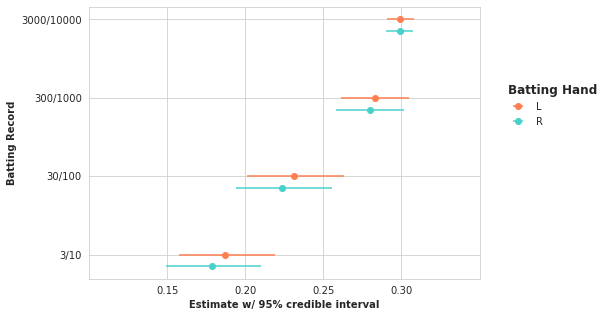

In [316]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Group by batting hand
    grouped = batter.groupby(by="Bats")
    y_jit = [np.arange(len(AB)),np.arange(len(AB))-.15]
    for (G,clr,yy) in zip(grouped,['coral','mediumturquoise'],y_jit):
        # get group
        name, group = G
        group = group.sort_values(by="AB",ascending=True)
        # Get credible intervals as list of tuples
        credible_intervals   = np.abs(group.loc[:,["cred_low_diff","cred_high_diff"]].transpose().to_numpy())
        ax.errorbar(x=group.loc[:,"eb_estimate"],y=yy,xerr=credible_intervals,color=clr,fmt='o',label=name)
            
    # Clean up
    ax.set_xticks([.15, .2,.25,.3],)
    ax.set_xlim(.1,.35)
    ax.legend(frameon=False,bbox_to_anchor=(1.05,.75),loc='upper left')   
    ax.get_legend().set_title("Batting Hand",prop = {'size':12,'weight': "bold"})
    ax.get_legend()._legend_box.align = "left"
    ax.set_yticks(np.arange(len(AB)))   
    yticklabs = [str(int(ii[0])) + "/" + str(int(ii[1])) for ii in zip(H,AB)]
    ax.set_yticklabels(yticklabs)
    ax.set_xlabel("Estimate w/ 95% credible interval",fontweight="bold")
    ax.set_ylabel("Batting Record",fontweight="bold")


## 8.3 Over time

In [317]:
from pybaseball.lahman import batting
batting_data = batting()

def get_year(row,batting_data):
    row["Year"] = batting_data.loc[batting_data.playerID.isin([row.playerID]),"yearID"].item()
    row["Decade"] = (row.Year//10)*10
    return row

# Get players that are needed, group by player, and take mean of their years played
batting_data = batting_data.loc[batting_data.playerID.isin(bd.playerID),["yearID","playerID"]].groupby(by="playerID",as_index=True).mean().astype(int).reset_index()
bd = bd.apply(lambda row: get_year(row,batting_data),axis=1)

## Figure 8.3
Boxplot of batting averages within each decade. To reduce the effect of noise, only players with more than 500 at-bats are included.

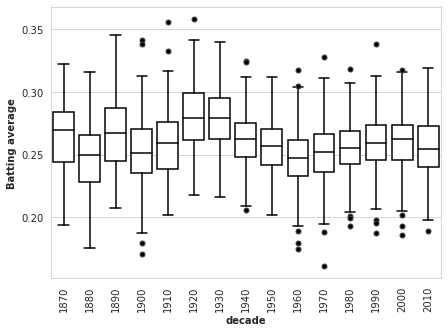

In [318]:

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    props = {'flierprops': {"markerfacecolor": 'k', "markersize": 5,
                "linestyle":'none',"marker": 'o'},
        'boxprops':{'facecolor':'w', 'edgecolor':'k'},
        'medianprops':{'color':'k'},
        'whiskerprops':{'color':'k'},
        'capprops':{'color':'k'}
    }
    sns.boxplot(data=bd.loc[bd.AB > 500,:],x="Decade",y="Avg",**props)
    ax.set_yticks([.2, .25, .3, .35])
    ax.set_xlabel("decade",fontweight="bold")
    ax.set_ylabel("Batting average",fontweight="bold")
    plt.xticks(rotation = 90)


The closest thing to `ns(year, df = 5)` in `R` is natural cubic regression splines using [`patsy`](https://patsy.readthedocs.io/en/latest/spline-regression.html?highlight=cr#natural-and-cyclic-cubic-regression-splines) in `python`.

In [368]:
# This is a clean up cell since rerunning the spline will add the same columns to the DF. Probably another way to handle this...
bd = bd.loc[:,['playerID',
 'AB',
 'H',
 'Name',
 'Avg',
 'eb estimate Avg',
 'alpha0',
 'beta0',
 'alpha1',
 'beta1',
 'eb estimate MLE',
 'eb estimate MCMC',
 'bats_B',
 'bats_L',
 'bats_R',
 'alpha0_bat',
 'beta0_bat',
 'alpha1_bat',
 'beta1_bat',
 'eb_estimate_bat',
 'Year',
 'Decade']]
 
# bd = bd.loc[:,~bd.columns.isin(["year_basis1","year_basis2","year_basis3"])]
bd

,playerID,AB,H,Name,Avg,eb estimate Avg,alpha0,beta0,alpha1,beta1,...,bats_B,bats_L,bats_R,alpha0_bat,beta0_bat,alpha1_bat,beta1_bat,eb_estimate_bat,Year,Decade
0,aaronha01,12364,3771,Hank Aaron,0.304998,0.303783,162.816130,406.183297,3933.816130,8999.183297,...,0,0,1,171.651724,433.569683,3942.651724,9026.569683,0.304001,1965,1960
1,aaronto01,944,216,Tommie Aaron,0.228814,0.237211,140.654632,428.344795,356.654632,1156.344795,...,0,0,1,148.256556,456.964852,364.256556,1184.964852,0.235122,1966,1960
2,abadan01,21,2,Andy Abad,0.095238,0.250730,107.869185,461.130242,109.869185,480.130242,...,0,1,0,118.956856,486.264551,120.956856,505.264551,0.193153,2003,2000
3,abadijo01,49,11,John Abadie,0.224490,0.255756,115.168694,453.830733,126.168694,491.830733,...,0,0,1,121.351885,483.869523,132.351885,521.869523,0.202304,1875,1870
4,abbated01,3044,772,Ed Abbaticchio,0.253614,0.254284,150.741140,418.258287,922.741140,2690.258287,...,0,0,1,158.904552,446.316855,930.904552,2718.316855,0.255097,1905,1900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9797,zuninmi01,2226,446,Mike Zunino,0.200359,0.208386,148.044922,420.954505,594.044922,2200.954505,...,0,0,1,156.058243,449.163164,602.058243,2229.163164,0.212650,2016,2010
9798,zupcibo01,795,199,Bob Zupcic,0.250314,0.253305,139.174705,429.824722,338.174705,1025.824722,...,0,0,1,146.694245,458.527162,345.694245,1054.527162,0.246885,1992,1990
9799,zupofr01,18,3,Frank Zupo,0.166667,0.255559,106.541170,462.458257,109.541170,477.458257,...,0,1,0,117.554914,487.666493,120.554914,502.666493,0.193438,1958,1950
9800,zuvelpa01,491,109,Paul Zuvella,0.221996,0.237758,135.023132,433.976295,244.023132,815.976295,...,0,0,1,142.311565,462.909842,251.311565,844.909842,0.229253,1986,1980


In [369]:
from patsy import dmatrix

# First output not dataframe for use on new data
# basis= dmatrix("bs(train['Year'],knots=(1890,1920,1960,2000),include_intercept=False)", {"train": bd[["Year"]]})
basis= dmatrix("cr(train['Year'],df=5)", {"train": bd[["Year"]]})

# Get dataframe for our existing data
basis_df = dmatrix("cr(train['Year'],df=5)", {"train": bd[["Year"]]}, return_type='dataframe').rename(columns={"cr(train['Year'], df=5)[0]": "year_basis1",
                                                                                                              "cr(train['Year'], df=5)[1]": "year_basis2",
                                                                                                              "cr(train['Year'], df=5)[2]": "year_basis3",
                                                                                                              "cr(train['Year'], df=5)[3]": "year_basis4",
                                                                                                              "cr(train['Year'], df=5)[4]": "year_basis5"})
# basis_df = dmatrix("cr(train['Year'],df=3)", {"train": bd[["Year"]]}, return_type='dataframe').rename(columns={"cr(train['Year'], knots=(1890,1920,1960))[0]": "year_basis1",
#                                                                                                               "cr(train['Year'], knots=(1890,1920,1960))[1]": "year_basis2",
#                                                                                                               "cr(train['Year'], knots=(1890,1920,1960))[2]": "year_basis3"})
# Add to existing dataframe                                                                                                              
bd = pd.concat([bd,basis_df.loc[:,basis_df.columns != "Intercept"]],axis=1)

In [370]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    # Get H/AB 
    k, n, r, l, b, y1, y2, y3, y4, y5 = args # H, AB, R-handed, L-handed, Both-handed, year 1, year 2, year 3 

    # The initial model assumed a fixed (alpha, beta):
    #        a, b = params[0], params[1]

    # Here, we take in the initial values of (mu_0, mu_ab, and sigma_0) to compute (alpha, beta):
    mu_0, mu_AB, sigma_0, r0, l0, b0, y1_0, y2_0, y3_0, y4_0, y5_0 = params
    # Add batting term
    year_term    = y1_0*y1 + y2_0*y2 + y3_0*y3 + y4_0+y4 + y5_0+y5
    batting_term = r0*r + l0*l + b0*b
    mu_i = mu_0 + mu_AB*np.log(n) + batting_term + year_term
    # (alpha,beta) as before
    a = mu_i / sigma_0
    b = (1-mu_i)/sigma_0
    
    # Log pdf
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #


min_atbat = 0

# I am going to cheat here and use the values from the book as initial parameters since MLE is probably not the best choice here.
init_params = [ 0.14348183, 0.01514047, 0.00175561,  0.01,       0.01,     0.01,      0.01,      0.01,      0.01,    0.01,      0.01]
param_bounds = [(0, 0.4), (0.001, 0.5),(.0001,.1),(-0.5,.5),  (-0.5,.5), (-0.5,.5), (-0.5,.5), (-0.5,.5), (-0.5,.5),(-0.5,.5), (-0.5,.5)]

# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(bd.loc[:,'H'], bd.loc[:,'AB'],bd.loc[:,'bats_R'],bd.loc[:,'bats_L'],bd.loc[:,'bats_B'], bd.loc[:,'year_basis1'], bd.loc[:,'year_basis2'], bd.loc[:,'year_basis3'],bd.loc[:,'year_basis4'],bd.loc[:,'year_basis5']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000},bounds=param_bounds)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70548D+06    |proj g|=  5.10000D-01

At iterate    1    f=  3.12505D+05    |proj g|=  1.00000D+00

At iterate    2    f=  3.12496D+05    |proj g|=  1.00000D+00

At iterate    3    f=  3.12496D+05    |proj g|=  1.00000D+00

At iterate    4    f=  3.12496D+05    |proj g|=  1.00000D+00

At iterate    5    f=  3.12496D+05    |proj g|=  9.99999D-01

At iterate    6    f=  3.12495D+05    |proj g|=  9.99999D-01

At iterate    7    f=  3.12495D+05    |proj g|=  9.99997D-01

At iterate    8    f=  3.12495D+05    |proj g|=  9.99994D-01

At iterate    9    f=  3.12495D+05    |proj g|=  9.99885D-01

At iterate   10    f=  3.12494D+05    |proj g|=  9.99868D-01

At iterate   11    f=  3.12494D+05    |proj g|=  9.99851D-01

At iterate   12    f=  3.12494D+05    |proj g|=  9.99862D-01

At iterate   13    f=  3.1

In [371]:
print(result)

      fun: 312488.8654608414
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.49614197e+02, -2.02701776e+03, -1.52376316e+06, -5.54695726e+02,
        3.79059930e+02, -3.73978401e+02, -2.08901474e+02, -8.34639650e+01,
       -2.34314939e+02, -5.49608376e+02, -5.49614197e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 588
      nit: 41
     njev: 49
   status: 0
  success: True
        x: array([ 0.39986667,  0.00101766,  0.1       ,  0.49997981, -0.5       ,
       -0.49999998, -0.49989963,  0.49961962, -0.49991873,  0.4998073 ,
        0.4998073 ])


In [373]:
def new_eb_estimate(row,params,col_names=["alpha0","beta0","alpha1","beta1","eb_estimate"]):

    # Get H,AB, and other params for each row
    H, AB, R, L, B, Y1, Y2, Y3, Y4, Y5 = row.H, row.AB, row.bats_R, row.bats_L, row.bats_B, row.year_basis1, row.year_basis2, row.year_basis3, row.year_basis4, row.year_basis5
    
    # Get values from MLE results
    mu, mu_AB, sigma, r_, l_, b_, y1_, y2_, y3_, y4_, y5_ = params

    # Update alpha0 and beta0
    year_term    = y1_*Y1 + y2_*Y2 + y3_*Y3 + y4_*Y4 + y5_*Y5 
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term + year_term) if AB > 0 else mu
    alpha0 = mu_i/sigma
    beta0 = (1-mu_i)/sigma

    # Update alpha1 and beta1
    alpha1 = alpha0 + H
    beta1  = beta0 + (AB - H)

    # New eb estimate
    new_eb_estimate = alpha1 / (alpha1 + beta1)

    # Update data
    row[col_names[0]] = alpha0 
    row[col_names[1]] = beta0 
    row[col_names[2]] = alpha1
    row[col_names[3]] = beta1
    row[col_names[4]] = new_eb_estimate

    return row

bd = bd.loc[bd.AB>0,:].apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0_year","beta0_year","alpha1_year","beta1_year","eb_estimate_year"]),axis=1)

## Figure 8.4
The prior distribution that would be used for a left- or right- handed player at a particular point in time. Shown are the mean and the 95% intervals for each prior.

In the book he shows the results for a hypothetical batter with `AB = 1000` with a `.250` batting average (I assume). I went ahead and made the plots for different averages and number of ABs. 

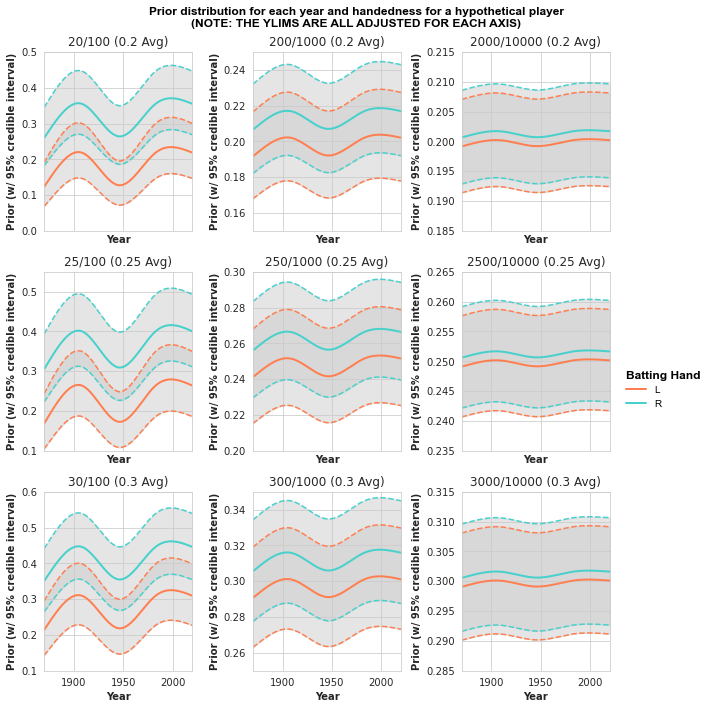

In [409]:
import itertools

# Compute credible intervals
def get_credible_intervals(data,ci=[0.025,0.975]):
        # Get explicit credible intervals
        data["cred_low"], data["cred_high"] = stats.beta.ppf(ci,data["alpha1_year"],data["beta1_year"])
        # Get difference between mean and CIs since that is what matplotlib.pyplot.errorbar wants
        data["cred_low_diff"], data["cred_high_diff"] = np.absolute(data["eb_estimate_year"]-data["cred_low"]), np.absolute(data["eb_estimate_year"]-data["cred_high"])
        return data


# Define "batters"
AB   = [100,1000,10000]
AVG  = [.2, .25, .3]

YEAR = np.arange(1870,2021)

out = patsy.dmatrix(basis.design_info, {'train': pd.DataFrame({"Year": YEAR})}, return_type='dataframe').rename(columns={"cr(train['Year'], df=5)[0]": "year_basis1",
                                                                                                              "cr(train['Year'], df=5)[1]": "year_basis2",
                                                                                                              "cr(train['Year'], df=5)[2]": "year_basis3",
                                                                                                              "cr(train['Year'], df=5)[3]": "year_basis4",
                                                                                                              "cr(train['Year'], df=5)[4]": "year_basis5"})
basis_data = pd.concat([out.loc[:,out.columns != "Intercept"],out.loc[:,out.columns != "Intercept"]],axis=0).reset_index()

with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(len(AB),len(AVG),sharey=False,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(10,10)
    
    yylims = [(0,0.5),(.15,.25),(.185,.215),(0.1,0.55),(.2,.3),(.235,.265),(.1,.6),(.25,.35),(.285,.315)]

    # Loop through each axis
    for (thisax,(aa,bb),yylim) in zip(ax.flatten(),list(itertools.product(*[AVG,AB])),yylims):
        # Set thisax as current axis
        plt.sca(thisax)
        
        # Define batter
        batter = pd.DataFrame({"Year": np.concatenate([YEAR,YEAR]), "AB":[bb]*2*len(YEAR), "Avg": len(YEAR)*2*[aa], "H": [aa*bb]*2*len(YEAR), "Bats": len(YEAR)*["R"] + len(YEAR)*["L"],"bats_R": len(YEAR)*[1] + len(YEAR)*[0],"bats_L": len(YEAR)*[0] + len(YEAR)*[1],"bats_B": len(YEAR)*[0] + len(YEAR)*[0]})
        # Add spline data
        batter = pd.concat([batter,basis_data],axis=1)
        # Add new EB estimate
        batter = batter.apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0_year","beta0_year","alpha1_year","beta1_year","eb_estimate_year"]),axis=1)
        # Add confidence intervals
        batter = batter.apply(lambda row: get_credible_intervals(row),axis=1)
        # Group by batting hand
        grouped = batter.groupby(by="Bats")

        for (G,clr) in zip(grouped,['coral','mediumturquoise']):
            # get group
            name, group = G
            # Get credible intervals as list of tuples
            credible_intervals   = np.abs(group.loc[:,["cred_low_diff","cred_high_diff"]].transpose().to_numpy())
            thisax.fill_between(group.loc[:,"Year"],group.loc[:,"cred_low"], group.loc[:,"cred_high"],color=3*[.8],alpha=0.5)
            thisax.plot(group.loc[:,"Year"],group.loc[:,"eb_estimate_year"],color=clr,lw=2,label=name)
            thisax.plot(group.loc[:,"Year"],group.loc[:,"cred_high"],color=clr,linestyle='--')
            thisax.plot(group.loc[:,"Year"],group.loc[:,"cred_low"],color=clr,linestyle='--')
                
        # # Clean up
        # thisax.set_yticks([.1, .2,.3,.4,.5])
        thisax.set_ylim(yylim)
        thisax.set_xlim(bd.Decade.min(),bd.Decade.max())
        # thisax.set_xticks(sorted(bd.Decade.unique()))
        thisax.set_ylabel("Prior (w/ 95% credible interval)",fontweight="bold")
        thisax.set_xlabel("Year",fontweight="bold")
        thisax.set_title("{}/{} ({} Avg)".format(int(aa*bb),bb,aa))
        
ax[1,2].legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))
ax[1,2].get_legend().set_title("Batting Hand",prop = {'size':12,'weight': "bold"})
ax[1,2].get_legend()._legend_box.align = "left"
fig.suptitle("Prior distribution for each year and handedness for a hypothetical player\n(NOTE: THE YLIMS ARE ALL ADJUSTED FOR EACH AXIS)",fontweight="bold")
plt.tight_layout()



In the figure above, the y-limits are adjusted to show the curvature of each spline. In the the figure below, the limits are fixed so we can see that the EB-estimates converge on the true average when the number of ABs is high. 

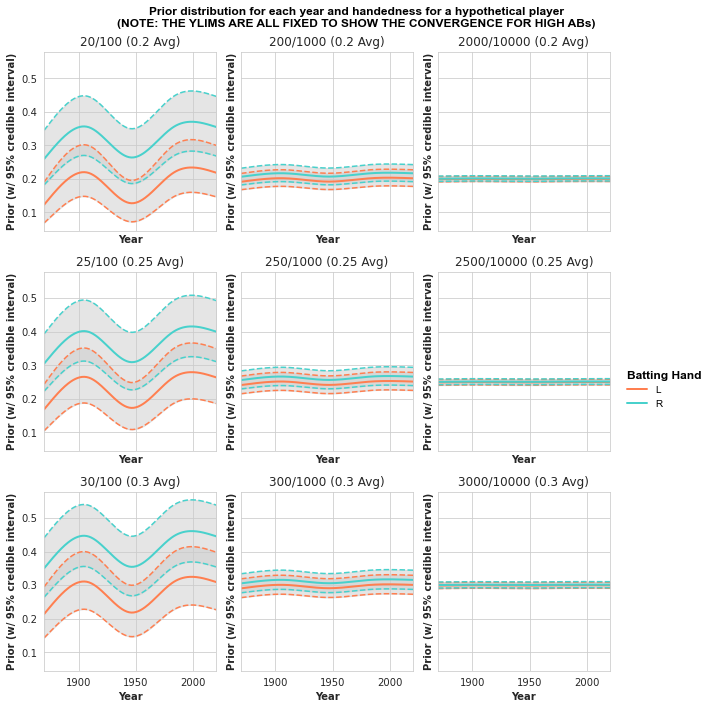

In [410]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(len(AB),len(AVG),sharey=True,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(10,10)
    
    yylims = [(0,0.5),(.15,.25),(.185,.215),(0.1,0.55),(.2,.3),(.235,.265),(.1,.6),(.25,.35),(.285,.315)]

    # Loop through each axis
    for (thisax,(aa,bb),yylim) in zip(ax.flatten(),list(itertools.product(*[AVG,AB])),yylims):
        # Set thisax as current axis
        plt.sca(thisax)
        
        # Define batter
        batter = pd.DataFrame({"Year": np.concatenate([YEAR,YEAR]), "AB":[bb]*2*len(YEAR), "Avg": len(YEAR)*2*[aa], "H": [aa*bb]*2*len(YEAR), "Bats": len(YEAR)*["R"] + len(YEAR)*["L"],"bats_R": len(YEAR)*[1] + len(YEAR)*[0],"bats_L": len(YEAR)*[0] + len(YEAR)*[1],"bats_B": len(YEAR)*[0] + len(YEAR)*[0]})
        # Add spline data
        batter = pd.concat([batter,basis_data],axis=1)
        # Add new EB estimate
        batter = batter.apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0_year","beta0_year","alpha1_year","beta1_year","eb_estimate_year"]),axis=1)
        # Add confidence intervals
        batter = batter.apply(lambda row: get_credible_intervals(row),axis=1)
        # Group by batting hand
        grouped = batter.groupby(by="Bats")

        for (G,clr) in zip(grouped,['coral','mediumturquoise']):
            # get group
            name, group = G
            # Get credible intervals as list of tuples
            credible_intervals   = np.abs(group.loc[:,["cred_low_diff","cred_high_diff"]].transpose().to_numpy())
            thisax.fill_between(group.loc[:,"Year"],group.loc[:,"cred_low"], group.loc[:,"cred_high"],color=3*[.8],alpha=0.5)
            thisax.plot(group.loc[:,"Year"],group.loc[:,"eb_estimate_year"],color=clr,lw=2,label=name)
            thisax.plot(group.loc[:,"Year"],group.loc[:,"cred_high"],color=clr,linestyle='--')
            thisax.plot(group.loc[:,"Year"],group.loc[:,"cred_low"],color=clr,linestyle='--')
                
        # # Clean up
        thisax.set_yticks([.1, .2,.3,.4,.5])
        thisax.set_xlim(bd.Decade.min(),bd.Decade.max())
        # thisax.set_xticks(sorted(bd.Decade.unique()))
        thisax.set_ylabel("Prior (w/ 95% credible interval)",fontweight="bold")
        thisax.set_xlabel("Year",fontweight="bold")
        thisax.set_title("{}/{} ({} Avg)".format(int(aa*bb),bb,aa))

ax[1,2].legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))
ax[1,2].get_legend().set_title("Batting Hand",prop = {'size':12,'weight': "bold"})
ax[1,2].get_legend()._legend_box.align = "left"
fig.suptitle("Prior distribution for each year and handedness for a hypothetical player\n(NOTE: THE YLIMS ARE ALL FIXED TO SHOW THE CONVERGENCE FOR HIGH ABs)",fontweight="bold")
plt.tight_layout()